Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random
import warnings




from matplotlib import style
from sklearn import ensemble
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime
from pylab import rcParams


plt.style.use(['Solarize_Light2'])
%matplotlib inline
warnings.filterwarnings('ignore')


matplotlib.rcParams.update({'font.size':14})



In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    '''plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()'''

Описание датасета

Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры


In [3]:
train_df = pd.read_csv('train.csv')

In [4]:
test_df = pd.read_csv('test.csv')

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

##### Подготавливаем датасеты. Меняем серийные атрибуты на тип строка.


In [6]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

##### Разведочный анализ данных (Exploratory Data Analysis)
Исследуем целевую переменуную, уберем выбросы, заполним отсутствующие значения.

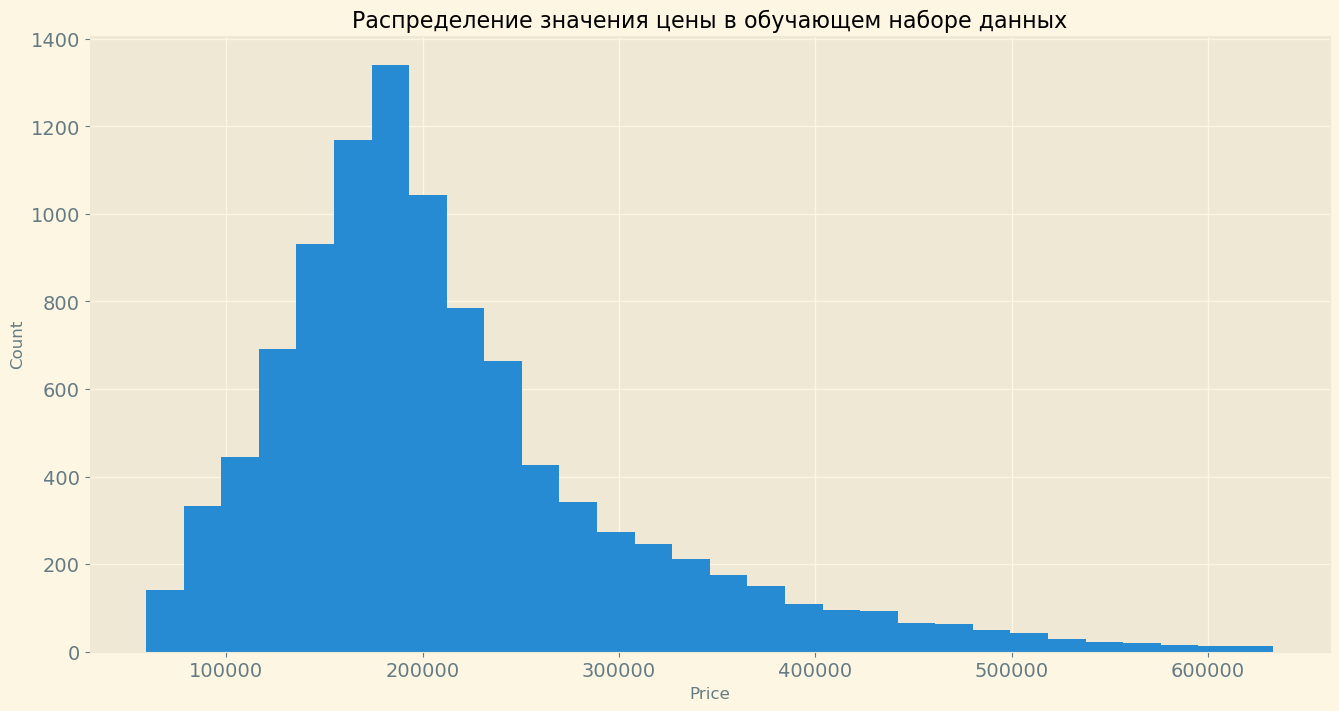

In [7]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title("Распределение значения цены в обучающем наборе данных")
plt.show()


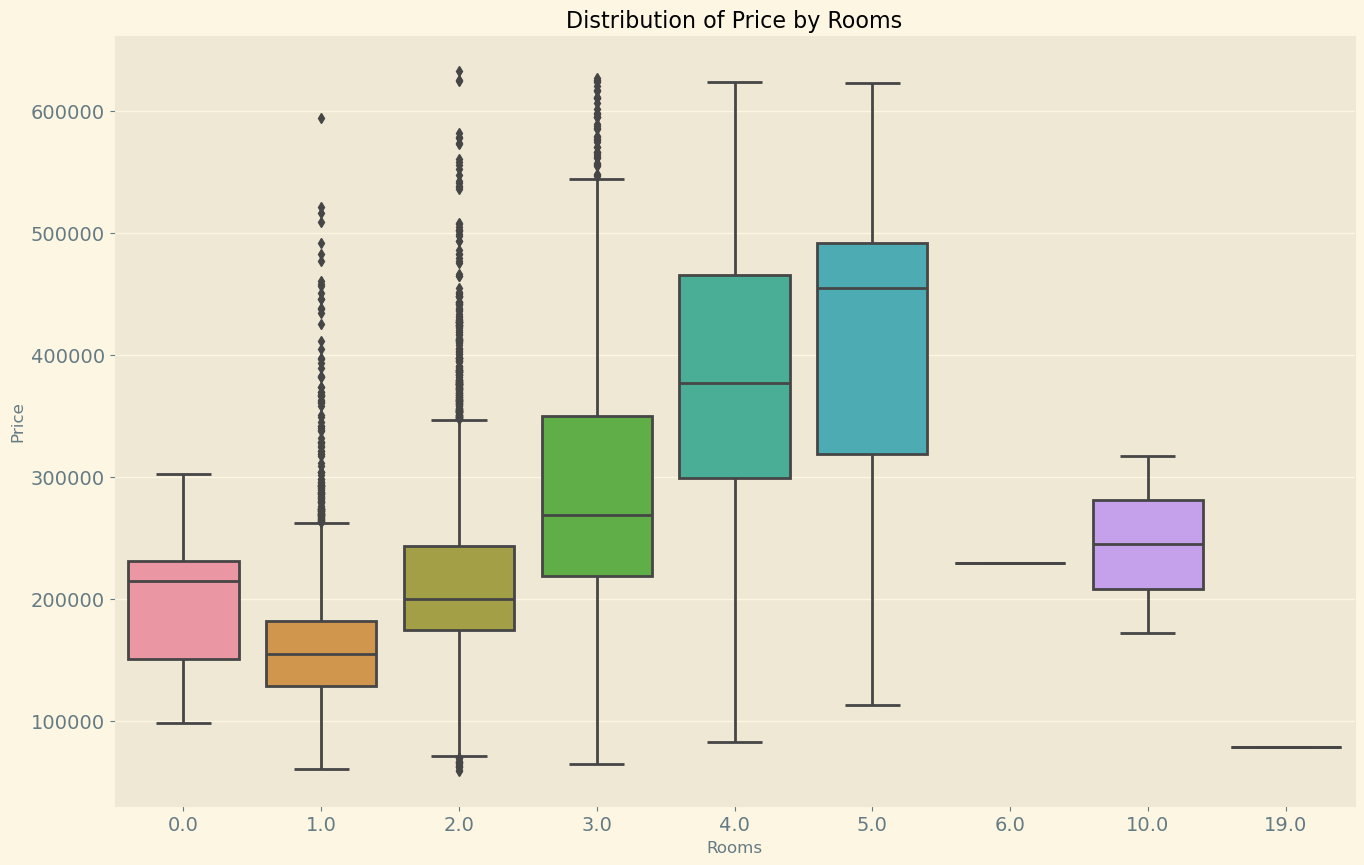

In [8]:
plt.figure(figsize=(16, 10))
sns.boxplot(train_df['Rooms'], train_df['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Distribution of Price by Rooms')
plt.show()

In [9]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],
      dtype=object)

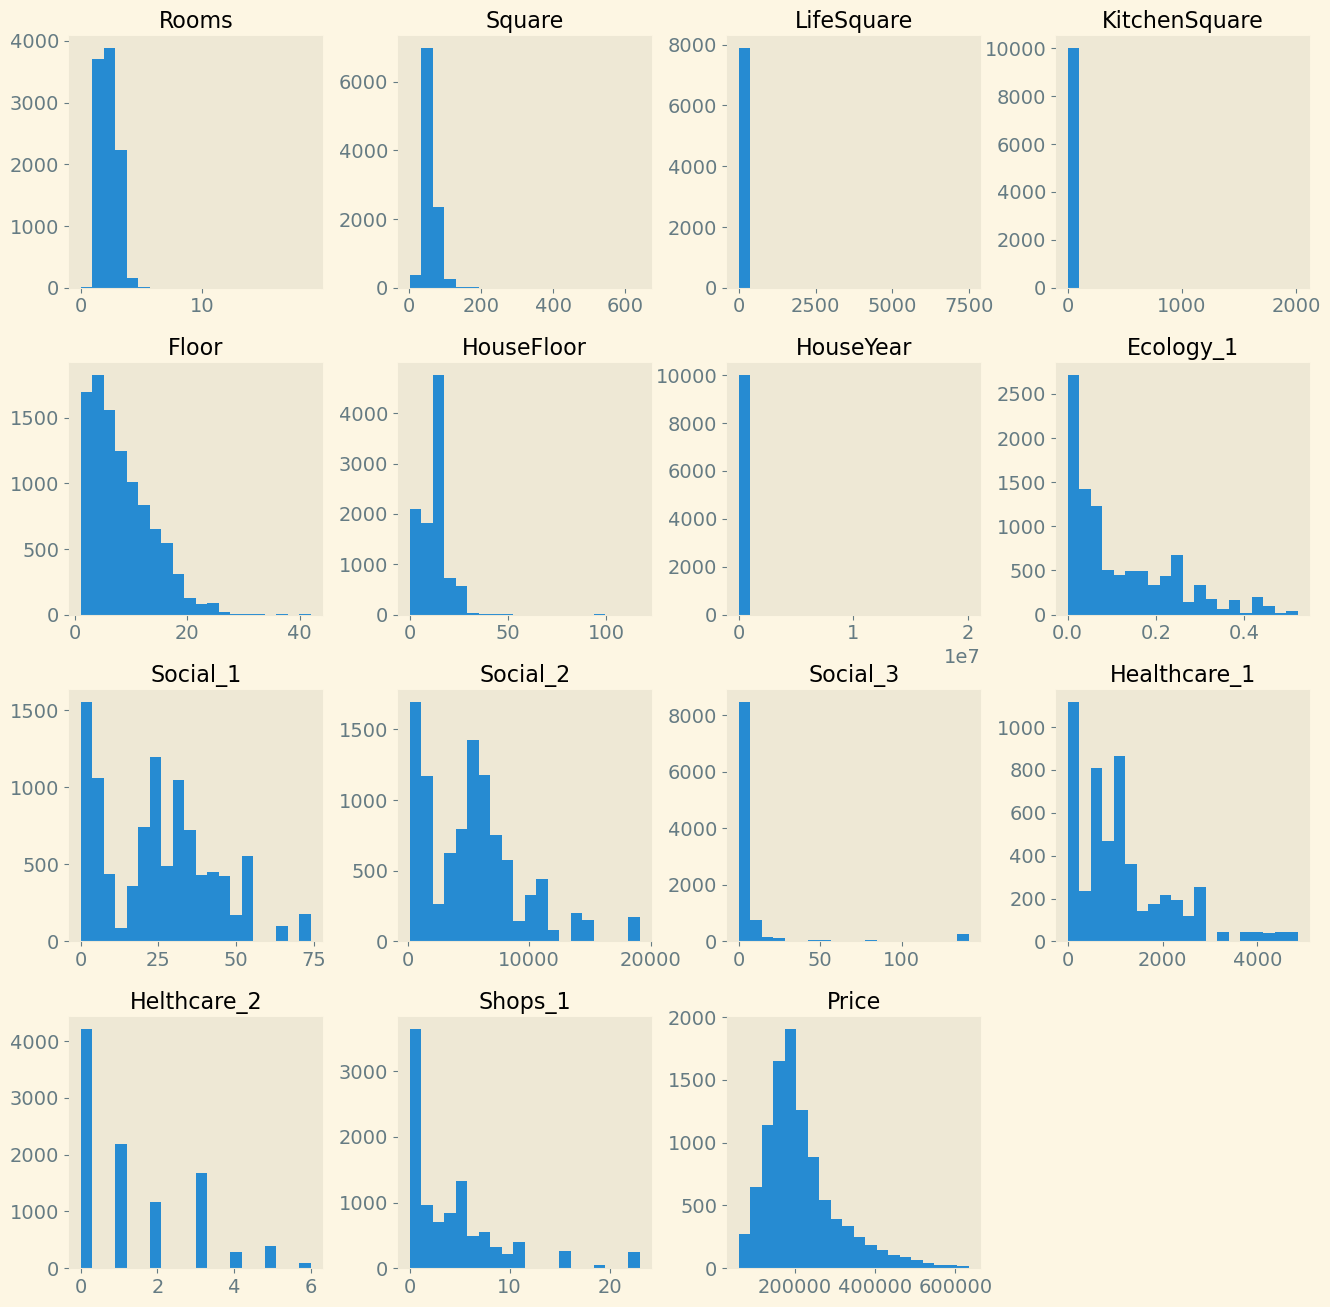

In [10]:
df_num_features = train_df.select_dtypes(exclude='object')

df_num_features.hist(figsize=(16, 16), bins=20, grid=False)

Номинативные переменные

In [11]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [12]:
train_df['DistrictId'].value_counts() #смотрим расброс данных

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [13]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [14]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [15]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## 2. Обработка выбросов

##### Rooms

In [16]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
train_df['Rooms_outlier']=0 #создаем переменную, которая позволит разобраться, что мы изменилии в датасете
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.930730,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,...,B,46,7960,6,350.0,3,11,B,196684.316040,0
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,...,B,30,5562,0,NaN,0,5,A,189050.289571,0
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,...,B,2,629,1,NaN,0,0,A,159143.805370,0
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,...,A,30,5048,9,325.0,2,5,B,181595.339808,0


In [18]:
train_df['Rooms_outlier'].value_counts()

0    9988
1      12
Name: Rooms_outlier, dtype: int64

In [19]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1 #заменим, сведения о ноль комнатах на одну комнату
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median() #заменим, сведения о больше либо равно шести комнатах на медиану

In [20]:
train_df['Rooms'].head()

0    2.0
1    3.0
2    2.0
3    2.0
4    1.0
Name: Rooms, dtype: float64

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [22]:
train_df = train_df.astype({'Id': np.int64, 'DistrictId': np.int64})

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

##### KitchenSquare

In [24]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
32.0         2
41.0         2
51.0         2
30.0         2
112.0        2
37.0         2
43.0         2
25.0         2
58.0         2
84.0         1
75.0         1
21.0         1
54.0         1
62.0         1
40.0         1
29.0         1
1970.0       1
27.0         1
39.0         1
35.0         1
23.0         1
73.0         1
31.0         1
60.0         1
63.0         1
42.0         1
36.0         1
96.0         1
26.0         1
53.0         1
78.0         1
66.0         1
2014.0       1
48.0         1
72.0         1
123.0        1
Name: KitchenSquare, dtype: int64

<AxesSubplot:xlabel='KitchenSquare'>

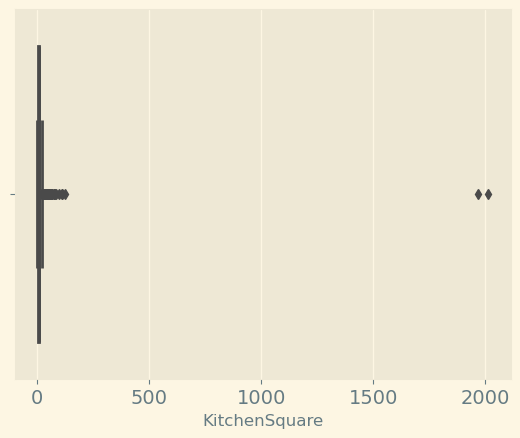

In [25]:
sns.boxplot(train_df.KitchenSquare)

In [26]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [27]:
train_df['KitchenSquare'].quantile(.975),train_df['KitchenSquare'].quantile(.025),

(13.0, 0.0)

In [28]:
condition = (train_df['KitchenSquare'].isna()) \
                | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))

train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
             
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3


In [29]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

##### Floor,	HouseFloor

In [30]:
train_df['HouseFloor'].sort_values().unique() #варианты этажности домов

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [31]:
train_df['Floor'].sort_values().unique() #варианты этажей квартир

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [32]:
train_df['HouseFloor_outlier'] = 0 #создаем переменную, которая позволит разобраться, что мы изменилии в датасете
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [33]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [34]:
#находим значения,где этаж квартиры больше этажа дома
floor_outlier = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outlier 

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [35]:
#исправляем ошибку рандомом по этажности дома
train_df.loc[floor_outlier, 'Floor'] = train_df.loc[floor_outlier, 'HouseFloor']\
    .apply(lambda x: random.randint(1, x))

In [36]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

##### HouseYear

In [37]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [38]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011

In [39]:
train_df['HouseYear'].sort_values(ascending=False)

3357    2020
3485    2020
8253    2020
790     2020
3859    2020
        ... 
7611    1916
910     1914
2656    1912
5111    1912
9317    1910
Name: HouseYear, Length: 10000, dtype: int64

## 3. Обработка пропусков

##### LifeSquare            

In [40]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [41]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna()*1

condition = (train_df['LifeSquare'].isna()) \
    & (~train_df['Square'].isna()) \
    & (~train_df['KitchenSquare'].isna()) # ~ оператор 'нет', т.е. где значения заполнены

condition2 = (~train_df['LifeSquare'].isna()) & (~train_df['Square'].isna()) \
    & (~train_df['KitchenSquare'].isna()) # условие чтобы везде было не ноль

train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
    - train_df.loc[condition, 'KitchenSquare'] \
    - (train_df.loc[condition2,'Square'].median() - train_df.loc[condition2, 'LifeSquare'].median() - train_df.loc[condition2, 'KitchenSquare'].median())
# в последней строке вычисляем среднюю велечину нежилой площади за минусом кухни (она нам и так известна)
# это для расчета средней площади туалета, ванной и прихожей    



In [42]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,NaN,0,11,B,184966.930730,0,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.450063,0,0,0
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.908524,0,0,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,0,0,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,3,5.0,1968,0.135650,...,7960,6,350.0,3,11,B,196684.316040,0,1,0
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,...,5562,0,NaN,0,5,A,189050.289571,0,0,0
9997,5123,27,1.0,47.939008,33.847621,3.0,12,16.0,2015,0.072158,...,629,1,NaN,0,0,A,159143.805370,0,0,1
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,...,5048,9,325.0,2,5,B,181595.339808,0,0,0


##### Healthcare_1

In [43]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

### Создаем класс по подготовке данных

In [44]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None

    def fit(self, X):
        """Сохранение статистик"""
        #Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)


    def transform(self, X):
        """Трансформация данных"""
        
        #Комнаты
        X['Rooms_outlier']=0 #создаем переменную, которая позволит разобраться, что мы изменилии в датасете
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1

        X.loc[X['Rooms'] == 0, 'Rooms'] = 1 #заменим, сведения о ноль комнатах на одну комнату
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] #заменим, сведения о больше либо равно шести комнатах на медиану

        #Кухня площадь
        condition = (X['KitchenSquare'].isna()) \
                | (X['KitchenSquare'] > self.kitchen_square_quantile)

        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
             
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3

        #Floor, HouseFloor
        X['HouseFloor_outlier'] = 0 #создаем переменную, которая позволит разобраться, что мы изменилии в датасете
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1

        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']

        #находим значения,где этаж квартиры больше этажа дома
        floor_outlier = X.loc[X['Floor'] > X['HouseFloor']].index
        #исправляем ошибку рандомом по этажности дома
        X.loc[floor_outlier, 'Floor'] = X.loc[floor_outlier, 'HouseFloor']\
                .apply(lambda x: random.randint(1, x))


        #HouseYear
        X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968
        X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = 2011

        current_year = datetime.now().year

        X['HouseYear_outler'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outler'] = 1

        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        #Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        #LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1

        condition = (X['LifeSquare'].isna()) \
                & (~X['Square'].isna()) \
                & (~X['KitchenSquare'].isna()) # ~ оператор 'нет', т.е. где значения заполнены

        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] \
                - (self.medians['Square'] - self.medians['LifeSquare'] - self.medians['KitchenSquare'])
        # в последней строке вычисляем значениее средней велечины нежилой площади за минусом кухни (она нам и так известна)
        # это для расчета средней площади туалета, ванной и прихожей    


        

        X.fillna(self.medians, inplace=True)

        return X

### 4. Создаем новые признаки

##### Менеяем бинарные значения А и В на числовые

In [45]:
binary_to_numbers = {'A':0,'B':1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [46]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,33,7976,5,0,11,1,184966.930730,0,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,46,10309,1,1,16,1,300009.450063,0,0,0
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,34,7759,0,1,3,1,220925.908524,0,0,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,23,5735,3,0,5,1,175616.227217,0,0,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,35,5776,1,2,4,1,150226.531644,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,3,5.0,1968,0.135650,...,46,7960,6,3,11,1,196684.316040,0,1,0
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,...,30,5562,0,0,5,0,189050.289571,0,0,0
9997,5123,27,1.0,47.939008,33.847621,3.0,12,16.0,2015,0.072158,...,2,629,1,0,0,0,159143.805370,0,0,1
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,...,30,5048,9,2,5,1,181595.339808,0,0,0


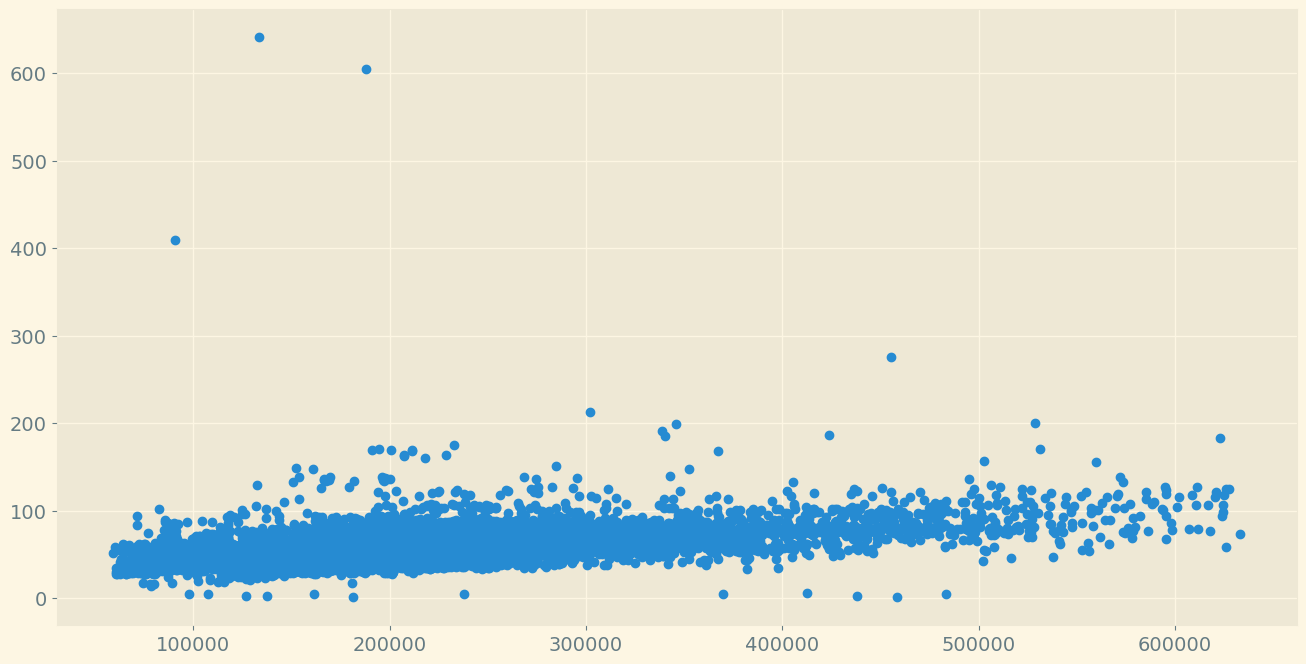

In [47]:
rcParams['figure.figsize'] = 16, 8
plt.scatter(train_df.Price, train_df.Square)

##### DistrictSize

In [48]:
#создаем новый признак
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns=\
            {'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [49]:
#добавляем его в наш дата фрейм
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,1,184966.930730,0,0,0,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,1,300009.450063,0,0,0,87
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,7759,0,1,3,1,220925.908524,0,0,0,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,1,175616.227217,0,0,0,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,1,150226.531644,0,0,0,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,3,5.0,1968,0.135650,...,7960,6,3,11,1,196684.316040,0,1,0,34
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,...,5562,0,0,5,0,189050.289571,0,0,0,51
9997,5123,27,1.0,47.939008,33.847621,3.0,12,16.0,2015,0.072158,...,629,1,0,0,0,159143.805370,0,0,1,851
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,...,5048,9,2,5,1,181595.339808,0,0,0,66


In [50]:
class FeatureGenerator():
        '''Генератор новых признаков'''

        def __init__(self):
            self.binary_to_numbers = None
            

        def fit(self, X, y=None):
            X = X.copy()        

            # Меняем бинарные значения А и В на числовые
            self.binary_to_numbers = {'A':0,'B':1}

            #создаем новый признак DistrictSize
            self.district_size = X['DistrictId'].value_counts().reset_index().rename(columns=\
                {'index':'DistrictId', 'DistrictId':'DistrictSize'})
            
            df = X.copy()
            '''
            if y is not None:
                df['Price'] = y.values
                
                self.
            '''
            
        def transform(self, X):
            # Меняем бинарные значения А и В на числовые
            X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
            X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
            X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)   

            #добавляем DistrictSize в наш дата фрейм
            X = X.merge(self.district_size, on='DistrictId', how='left')
            
            X['new_district'] = 0
            X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
            
            X['DistrictSize'].fillna(5, inplace=True)
            
            return X
        
        

### 5. Отбор признаков

In [51]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize']

In [52]:
feature_names = ['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',]
new_feature_names = ['Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize']
target_name = ['Price']

### 6. Разбиение данных на train and test

In [53]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [54]:
X = train_df.drop(columns=target_name) 
y = train_df[target_name]

In [55]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [56]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [57]:
X_train.isna().sum().sum().sum(), X_valid.isna().sum().sum().sum(), test_df.isna().sum().sum().sum(),

(0, 0, 0)

In [58]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

In [59]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [60]:
X_train.isna().sum().sum().sum(), X_valid.isna().sum().sum().sum(), test_df.isna().sum().sum().sum(),

(0, 0, 0)

In [61]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [62]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 20), (3300, 20), (5000, 20))

In [63]:
X_train.isna().sum().sum().sum(), X_valid.isna().sum().sum().sum(), test_df.isna().sum().sum().sum(),

(0, 0, 0)

### 7. Построение модели

In [64]:
rf_model = RandomForestRegressor(random_state=21, criterion='squared_error')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

##### Оценка модели

In [65]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Train R2:	0.964
Test R2:	0.722


##### Кросс-валидация

In [66]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.7304699 , 0.74395234, 0.73394632, 0.72247659, 0.72717927])

In [67]:
cv_score.mean()

0.7316048836204244

##### Важность признаков

In [68]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_),
                                  columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.427684
19,DistrictSize,0.223513
12,Social_3,0.052145
2,LifeSquare,0.039461
7,Ecology_1,0.039371
6,HouseYear,0.037854
11,Social_2,0.033044
0,Rooms,0.032071
4,Floor,0.024835
10,Social_1,0.022980


### 8. Прогнозирование на тестовом датасете

In [69]:
test_df.shape

(5000, 20)

In [70]:
predictions = rf_model.predict(test_df)
predictions

array([159667.92505036, 212990.18856988, 195080.86749183, ...,
       324215.82743327, 197229.46952415, 178457.93477128])

In [71]:
submit = pd.read_csv('test.csv')
submit = submit[['Id']]

In [72]:
submit['Price'] = predictions
submit

,Id,Price
0,725,159667.925050
1,15856,212990.188570
2,5480,195080.867492
3,15664,314288.845210
4,14275,146131.670055
...,...,...
4995,8180,253578.714596
4996,4695,133245.506388
4997,5783,324215.827433
4998,4780,197229.469524


In [73]:
submit.to_csv('NTretyakov_predictions.csv', index=False)